In [1]:
import glob
import json
import os
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_dataset_elements(dataset_root):
    elements = []
    
    for image in glob.glob(os.path.join(dataset_root, "images", "IMG_*.jpeg")):
        image_name = os.path.basename(image)
        labels_name = image_name.replace("image", "labels")
        labels_name = "{}.json".format(os.path.splitext(labels_name)[0])
        
        with open(os.path.join(dataset_root, "labels", labels_name)) as labels_file:
            raw_labels = json.load(labels_file)
            labels = []
            
            for label in ("plastic bags", "plastic bottles", "other plastic"):
                labels.append(1 if raw_labels[label] else 0)
                           
        elements.append((Image.open(image), labels))
                    
    return elements

In [3]:
class_names = ('plastic bags', 'plastic bottles', 'other plastic')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
if device == 'cpu':
    print(device)
else:
    print(torch.cuda.get_device_name())
    print(torch.__version__)
    print(torch.version.cuda)

NVIDIA GeForce GTX 1060
1.2.0
10.0


In [4]:
class MyDataset(Dataset):
  def __init__(self, data):#self, image_tensors, labels):
    data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    images = []
    labels = []
    for img, label in data:
        images.append(data_transforms(img))
        labels.append(label)
    #self.X = torch.tensor(imgs, dtype=torch.float32)
    self.X = images
    self.y = labels
    #print(len(self.X))
    
  def __getitem__(self,idx):
    data = self.X[idx]
    #data = self.X.iloc[idx.item()]
    label = torch.tensor(self.y[idx], dtype=torch.float32)
    

    #if self.y is not None:
      #  return (data, self.y[i])
    #else:
    
    return data, label
  
  def __len__(self):
    return len(self.X)

In [5]:
dataset_location_root_dir = 'Datasets' #Enter Dataset directry name from working root
data = load_dataset_elements(dataset_location_root_dir)
batch_size = len(data)
test_data = MyDataset(data)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                               shuffle=True, num_workers=0)

40


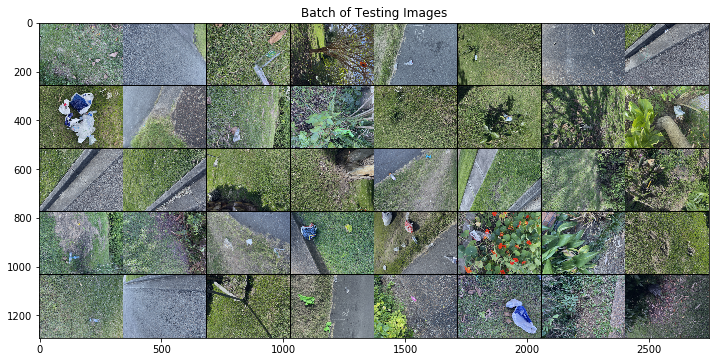

In [7]:
imgs, labs = next(iter(test_dataloader))
print(len(imgs))
plt.figure(figsize=(12,12))
#plt.axis("off")
plt.title("Batch of Testing Images")
plt.imshow(np.transpose(utils.make_grid(imgs.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

In [16]:
model = models.resnet50(pretrained=False) # load the pretrained model
num_features = model.fc.in_features
model.to(device)
# Load
'''
First Intialize the model and then just load it
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

'''

checkpoint = torch.load(Path("Q2LatestCheckpoint.pt"))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = batch_size #checkpoint['batch_size']

model.eval() ## or model.train()
optimizer

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "fc.0.weight", "fc.0.bias", "fc.2.weight", "fc.2.bias", "fc.2.running_mean", "fc.2.running_var", "fc.2.num_batches_tracked", "fc.4.weight", "fc.4.bias", "fc.6.weight", "fc.6.bias", "fc.6.running_mean", "fc.6.running_var", "fc.6.num_batches_tracked", "fc.8.weight", "fc.8.bias". 

In [12]:
image , label = next(iter(test_dataloader))
image = image.to(device)
label = label.to(device)
output = 0
with torch.no_grad():
  output = model(image)
  output = torch.sigmoid(output)
output = output>0.2

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [14]:
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])
def denormalize(image):
  image = image.to("cpu").clone().detach()
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) 
  image = torch.clamp(image,0,1)
  return image.numpy()

def visualize(image , actual , pred, index):
    fig,ax = plt.subplots()
    ax.imshow(denormalize(image))
    ax.grid(False)
    classes =  np.array(class_names)[np.array(actual,dtype=np.bool)]
    for i , s in enumerate(classes):
        ax.text(0 , i*20  , s , verticalalignment='top', color="white", fontsize=16, weight='bold')
  
    classes =  np.array(class_names)[np.array(pred,dtype=np.bool)]
    for i , s in enumerate(classes):
        ax.text(160 , i*20  , s , verticalalignment='top', color="orange", fontsize=16, weight='bold')

    fig.savefig('Pics/output'+str(index)+'.png')
    
    plt.show()

for i in range(batch_size):
    visualize(image[i] , label[i].tolist() , output[i].tolist(), i)

TypeError: 'int' object is not subscriptable

Hello Worls
